# 12. Strange Attractors

## Preamble

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root, fsolve, curve_fit
from scipy.misc import derivative
import scipy.linalg as lg
# PDF = Probability Distribution Function (smooth Histogram)
from scipy.stats import gaussian_kde as PDF  
# find maximas (peaks) in a list
from scipy.signal import find_peaks

import sympy as sp
import fractions as fra
import itertools as itr

# install the tabulate module using: "conda install tabulate"
from tabulate import tabulate

from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

## Utility functions

In [4]:
# chop(expr) = 0 if |expr| < delta
def chop(expr, delta=10**-10):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)


In [5]:
# Bifurcation diagram: x vs r
def BF_diag(f,x1,x2,r1,r2,nx=80,nr=80,col='k',title='',x_lab='$r$',y_lab='$x^\star$'):
    fx = lambda x,r: derivative(f,x,dx=1e-6,args=(r,))
    x=np.linspace(x1,x2,nx)
    r=np.linspace(r1,r2,nr)
    R,X = np.meshgrid(r,x)
    Z = f(X,R)
    Zx= fx(X,R)
    Zu= np.ma.masked_where(Zx<0,Z)
    Zs= np.ma.masked_where(Zx>0,Z)

    fig, ax=plt.subplots(figsize=(6,4))
    ax.contour(R,X,Zs,levels=[0],colors=col,linewidths=3)
    ax.contour(R,X,Zu,levels=[0],colors=col,linewidths=3,linestyles='dashed')
    ax.grid()
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title,color='b')
    plt.show()    

In [6]:
# Phase portrait: streamplot X,Y,Vx=dx/dt,Vy=dy/dt
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: streamlines through selected points
def PP_2d_sp(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    return ax    

# Phase portrait: streamlines through selected points + nullclines
def PP_2d_sp_nc(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Phase portrait: nullclines
def PP_nc(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,lw=1,c1='m',c2='b'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Display fixed points
def PP_FPs(FPs,tau,delta,ax):
    ax = ax or plt.gca()
    for j in np.arange(len(FPs)):
        FP_ = np.array(FPs[j],dtype=float) 
        if tau[j]<0 and delta[j]>0:
            print('stable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
        else:
            print('unstable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    return ax

In [7]:
def get_FP_data(f1,f2,tab=True):
    '''
    input: f1(x,y) and f2(x,y) for 2D dynamical system
    output: FPs and attributes: tau, delta, tau^2-4.delta, 
                                eigen-values/-vectors of Jacobian matrix
    '''
    FPs = sp.solve((f1(x,y),f2(x,y)),x,y) 
    FPsd= [{x:a[0],y:a[1]} for a in FPs]
    print('Fixed points: ',FPsd)

    A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
    display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))

    A_FPs = [A(x,y).subs(a) for a in FPsd]
    display(Latex(r'For each FP evaluate $A$, $\tau=Tr(A)$, $\Delta=det(A)$, $\tau^2-4\Delta$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
    [display(a) for a in A_FPs];

    tau   = [a.trace() for a in A_FPs]
    display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
    delta = [a.det()   for a in A_FPs]
    display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
    disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
    display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

    # calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
    eig_sys = [a.eigenvects() for a in A_FPs]
    mu = [[a[0][0],a[1][0]] for a in eig_sys]
    display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
    V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
    display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

    # tabulate data for FPs
    if tab :
        table=[[FPsd[i],tau[i],delta[i],disc[i],mu[i],V[i]] for i in np.arange(len(FPs))]
        print(tabulate(table,headers=('Fixed point','tau','delta','disc','lambda','eigenvectors'),
                   tablefmt='fancy_grid'))
    return FPs, tau, delta, disc, mu, V

In [8]:
# functions to calculate trajectory {x(t),y(t)} numerically for given {x0,y0} 
# input: functions f1,f2; duration T and timestep dt of trajectory; initial condition xy0=[x0,y0]
# output: [t,sol] = [t,[x(t),y(t)]]

def txy_traj(f1,f2,T,dt,xy0):
    t = np.arange(0,T+dt,dt)
    def RHS(xy,t):
        x,y=xy
        return[f1(x,y),f2(x,y)]
    sol = odeint(RHS,xy0,t)
    return [t,sol]

In [9]:
# functions to solve LE  
# input: parameters sigma,a,b; duration T and timestep dt; initial condition xyz0=[x0,y0,z0]
# output: [t,sol] = [t,[x(t),y(t),z(t)]]

def txyz_LE(sigma,r,b,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[sigma*(y-x),r*x-y-x*z,x*y-b*z]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

In [10]:
# functions to solve the Rossler system (RS) 
# input: parameters sigma,a,b; duration T and timestep dt; initial condition xyz0=[x0,y0,z0]
# output: [t,sol] = [t,[x(t),y(t),z(t)]]

def txyz_RS(a,b,c,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[-y-z,x+a*y,b+z*(x-c)]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

In [11]:
# NestList(f,x0,n0) and Nest(f,x,n)
def NestList(f,x0,n0):
    '''
    generate nested list by applying f n=0,...,n0 times on x0
    input:  f(x,_), x0, n0=integer
    output: [x0,f(x0),f(f(x0)),...,f(...(f(x0)))]
    '''
    return [a for a in itr.accumulate(itr.repeat(x0,n0),f)]

def Nest(f,x,n):
    '''Applies function f n-times to x'''
    if n==0:
        return x
    return Nest(f,f(x),n-1)

In [12]:
# define Logistic Map (LM) and LM series
f_LM = lambda x,r: r*x*(1-x)
def logistic_series(x0,r,n):
    f = lambda x,_: f_LM(x,r)
    return NestList(f,x0,n)

In [13]:
# plot cobweb x_(n+1)=f(x_n)
def cobweb_f(f,x0,n0,ax,ls='-',col='r',lw=1):
    ax = ax or plt.gca
    f_ = lambda x,_: f(x)
    dat = NestList(f_,x0,n0)
    x = list(itr.chain(*zip(dat,dat)))
    ax.plot(x[:-1],x[1:],c=col,ls=ls,lw=lw)
    return ax

# plot cobweb {x_0,...,x_n}
def cobweb_x(xdat,ax,ls='-',col='r',lw=1,nS=1):
    ax = ax or plt.gca
    x = list(itr.chain(*zip(xdat,xdat)))
    ax.plot(x[nS:-1],x[nS+1:],c=col,ls=ls,lw=lw)
    return ax

## Henon Map

The ___Henon map___ (HM) is defined by

$x_{n+1}=y_n+1-a x_n^2,\;\; y_{n+1}=b x_n$

HM can be obtained as a sequence of three simple transformations

   - $T_1: \quad x'=x,\;\; y'=1+y-ax^2\quad$  (stretch and fold)   
   - $T_2: \quad x'=bx,\;\; y'=y\quad$  (fold by contraction)
   - $T_3: \quad x'=y,\;\; y'=x\quad$  (reflection along x=y)

HM $= T3\cdot T2 \cdot T1$

In [14]:
# define HM and T_i, i=1,2,3
def fT1(xy,a):
    x,y = xy
    return [x,1+y-a*x**2]
def fT2(xy,b):
    x,y=xy
    return [b*x,y]
def fT3(xy):
    x,y=xy
    return [y,x]
def HM(xy,a,b):
    x,y=xy
    return [y+1-a*x**2,b*x]

# define HM series
def HM_series(xy0,a,b,n):
    f = lambda xy,_: HM(xy,a,b)
    return NestList(f,xy0,n)

#### Phase space region transformation

In [15]:
# generate a list of n0 uniformly distributed points on a circle (= phase space region)
Circ = lambda r0,n0: np.array([[r0*np.cos(t),r0*np.sin(t)] for t in np.linspace(0,2*np.pi,n0)])
# define the HM of the unit circle
HM_Circ = lambda a,b,r0,n0: np.array([HM(xy,a,b) for xy in Circ(r0,n0)])
# define intermediate transformations T1,T2,T3
sT1 = lambda a,s: np.array([fT1(xy,a) for xy in s])
sT2 = lambda b,s: np.array([fT2(xy,b) for xy in s])
sT3 = lambda   s: np.array([fT3(xy) for xy in s])

# genertate the phase space region and its HM map
r0_=4; n0_=100
a_=0.3; b_=0.3
s0 = Circ(r0_,n0_)
sHM= HM_Circ(a_,b_,r0_,n0_)

s1 = sT1(a_,s0)
s2 = sT2(b_,s1)
s3 = sT3(s2)

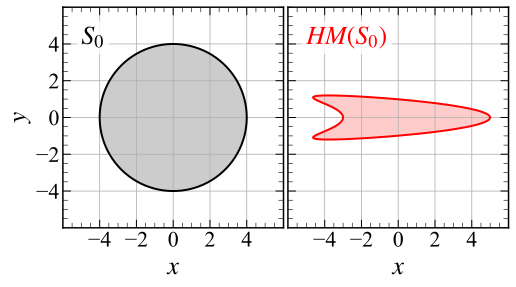

In [16]:
# plot the phase space region and its HM transformation
fig_HMT, ax=plt.subplots(1,2,figsize=(8,6),sharex=True,sharey=True,
                         gridspec_kw=dict(hspace=0.02,wspace=0.02))
ax[0].plot(s0.T[0],s0.T[1],'k-',lw=2)
ax[0].fill(s0.T[0],s0.T[1],'k',alpha=0.2)
ax[0].set_xlim(-6,6)
ax[0].set_ylim(-6,6)
ax[0].set_xticks(np.arange(-4,5,2))
ax[0].set_yticks(np.arange(-4,5,2))
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')

ax[1].plot(sHM.T[0],sHM.T[1],'r-',lw=2)
ax[1].fill(sHM.T[0],sHM.T[1],'r',alpha=0.2)
ax[1].set_xlabel('$x$')
# ax[1].set_ylabel('$y$')
[a.grid() for a in ax]
[a.set_aspect('equal') for a in ax]

ax[0].text(-5,4,'$S_0$',fontsize=26,bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))
ax[1].text(-5,4,'$HM(S_0)$',color='r',fontsize=26,bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))
# fig_HMT.savefig('FIGS/12_HMT.pdf')
plt.show()

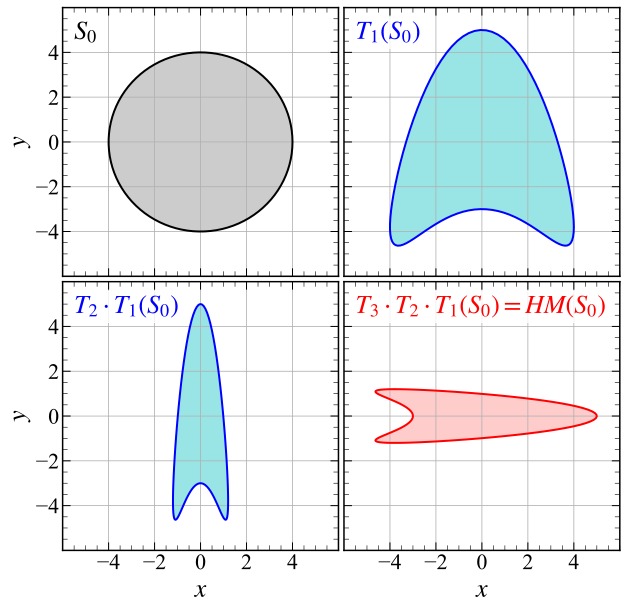

In [17]:
# plot the phase space region and its transformations trhough T1,T2 and T3
fig_S0T, ax=plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True,
                         gridspec_kw=dict(hspace=0.02,wspace=0.02))
ax[0,0].plot(s0.T[0],s0.T[1],'k-',lw=2)
ax[0,0].fill(s0.T[0],s0.T[1],'k',alpha=0.2)
ax[0,0].set_xlim(-6,6)
ax[0,0].set_ylim(-6,6)
ax[0,0].set_xticks(np.arange(-4,5,2))
ax[0,0].set_yticks(np.arange(-4,5,2))

ax[0,0].set_ylabel('$y$')
ax[1,0].set_ylabel('$y$')

ax[0,1].plot(s1.T[0],s1.T[1],'b-',lw=2)
ax[0,1].fill(s1.T[0],s1.T[1],'c',alpha=0.4)
ax[1,0].plot(s2.T[0],s2.T[1],'b-',lw=2)
ax[1,0].fill(s2.T[0],s2.T[1],'c',alpha=0.4)
ax[1,1].plot(s3.T[0],s3.T[1],'r-',lw=2)
ax[1,1].fill(s3.T[0],s3.T[1],'r',alpha=0.2)

ax[1,0].set_xlabel('$x$')
ax[1,1].set_xlabel('$x$')
[a.grid() for a in ax.reshape(-1)]

tx=-5.5;ty=4.6
ax[0,0].text(tx,ty,'$S_0$',fontsize=26,bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))
ax[0,1].text(tx,ty,'$T_1(S_0)$',color='b',fontsize=26,bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))
ax[1,0].text(tx,ty,'$T_2\cdot T_1(S_0)$',color='b',fontsize=26,bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))
ax[1,1].text(tx,ty,'$T_3\cdot T_2\cdot T_1(S_0)=HM(S_0)$',color='r',fontsize=26,bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))
# fig_S0T.savefig('FIGS/12_T1-T3.pdf')
plt.show()

#### Plot HM strange attractor for $a=1.4$ and $b=0.3$ 

In [23]:
box = lambda x1,x2,y1,y2:[[x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1]]
s1 = np.array(HM_series([0,0],a=1.4,b=0.3,n=10000))[1000:]

fig_HM1, ax=plt.subplots(figsize=(6,4))
ms=0.8
xy = np.array
ax.plot(s1.T[0],s1.T[1],'o',ms=ms,mfc='r',mec='r',mew=ms)
bb = box(0.5,0.75,0.15,0.21)
ax.plot(bb[0],bb[1],'k-',lw=1)

ax.set_xlabel('$x_n$')
ax.set_ylabel('$y_n$')
ax.set_xlim(-1.4,1.4)
ax.set_ylim(-0.4,0.4)
ax.set_xticks(np.arange(-1,1.4,0.5))
ax.grid()
# close figure [fig_HM1] to avoid displaying it in the notebook (otherwise notebook becomes slugish)
plt.close(fig_HM1)
fig_HM1.savefig('Downloads/12_HM_1b_.pdf')

In [24]:
# zoom in ...
s1 = np.array(HM_series([0,0],a=1.4,b=0.3,n=30000))[1000:]
fig_HM2, ax=plt.subplots(figsize=(6,4))
ms=0.8
xy = np.array
ax.plot(s1.T[0],s1.T[1],'o',ms=ms,mfc='r',mec='r',mew=ms)
bb = box(0.620,0.640,0.185,0.191)
ax.plot(bb[0],bb[1],'k-',lw=1)

ax.set_xlabel('$x_n$')
ax.set_ylabel('$y_n$')
ax.set_xlim(0.5,0.75)
ax.set_ylim(0.15,0.21)
ax.grid()
plt.close(fig_HM2) 
fig_HM2.savefig('Downloads/12_HM_1c_.pdf')

In [25]:
# zoom in again ...
s1 = np.array(HM_series([0,0],a=1.4,b=0.3,n=500000))[1000:]
fig_HM3, ax=plt.subplots(figsize=(6,4))
ms=0.8
xy = np.array
ax.plot(s1.T[0],s1.T[1],'o',ms=ms,mfc='r',mec='r',mew=ms)

ax.set_xlabel('$x_n$')
ax.set_ylabel('$y_n$')
ax.set_xlim(0.620,0.640)
ax.set_ylim(0.185,0.191)
ax.grid()
plt.close(fig_HM3)
fig_HM3.savefig('Downloads/12_HM_1d_.pdf')

## Rossler system (RS)

$\dot{x}=-y-z$ <br>
$\dot{y}=x+ay$ <br>
$\dot{z}=b+z(x-c)$

#### Solve RS for $a=b=0.2$, $c=5.7$ and plot 3D trajectory

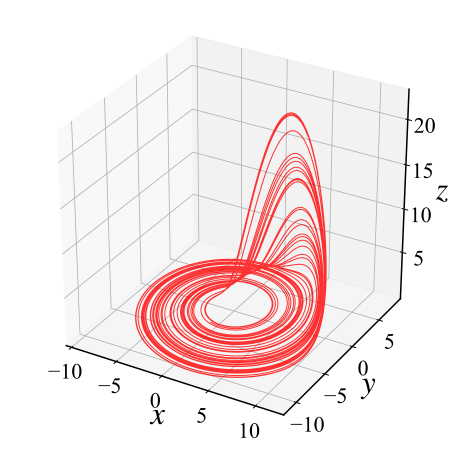

In [26]:
# define duration (T) and time-step (dt) and initial conditions (xyz0)
T=500; dt=0.02
xyz0 = [1,1,0]
t0=0.5*T; t0_=int(t0/dt)

plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=False

# solve RS
a0=b0=0.2; c0=5.7
t, xyz = txyz_RS(a0,b0,c0,T,dt,xyz0)

# plot 3D trajectory
fig_RS3d, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection':'3d'})
# 0<t<T
# ax.plot(xyz[:,0],xyz[:,1],xyz[:,2],'b',lw=1,alpha=0.8)
# t0<t<T
ax.plot(xyz[t0_:,0],xyz[t0_:,1],xyz[t0_:,2],'r',lw=1,alpha=0.8)

ax.set_xlabel('$x$', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_zlabel('$z$', fontsize=32)
# plt.savefig('FIGS/12_RS_3D.pdf')
plt.show()

In [ ]:
# plot 3D trajectory for t0<t<t1
t1=0.59*T; t1_=int(t1/dt)

@interact(tt=(t0,t1,50*dt))
def update(tt=t0):
    tt_=int(tt/dt)
    fig_RS3d, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection':'3d'})
    ax.plot(xyz[t0_:tt_,0],xyz[t0_:tt_,1],xyz[t0_:tt_,2],'r',lw=1,alpha=0.8)

    ax.set_xlabel('$x$', fontsize=32)
    ax.set_ylabel('$y$', fontsize=32)
    ax.set_zlabel('$z$', fontsize=32)
    ax.axes.set_xlim3d(-10,13)
    ax.axes.set_ylim3d(-14,9)
    ax.axes.set_zlim3d(1,20)
    plt.show()

#### RS:  plot $y$ vs $x$ 

In [ ]:
# plot RS trajectories projected on x-y, for t0<t<T
fig_xy, ax = plt.subplots(figsize=(6,6))
ax.plot(xyz[t0_:,0],xyz[t0_:,1],c='r',lw=1)

ax.set_xticks(np.arange(-10,15,5))
ax.set_yticks(np.arange(-10,15,5))
ax.tick_params(axis='both', labelsize=18)   
ax.set_xlim(-11,13)
ax.set_ylim(-12,9)
ax.grid()

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
# fig_xy.savefig('FIGS/12_RS_xy.pdf')
plt.show()                

#### RS:  calculate fixed points (FPs) and eigenvalues/eigenvectors of the linearized model 

In [ ]:
x,y,z = sp.symbols('x,y,z',real=True)
a,b,c = sp.symbols('a,b,c',real=True)
f1 = lambda x,y,z: -y-z
f2 = lambda x,y,z: x + a*y
f3 = lambda x,y,z: b + z*(x-c)
FPs = sp.solve((f1(x,y,z),f2(x,y,z),f3(x,y,z)),x,y,z) 
FPsd= [{x:a[0],y:a[1],z:a[2]} for a in FPs]
print('Fixed points: ')
[display(Latex('$x={}, y={}, z={}$'.format(sp.latex(a[0]),sp.latex(a[1]),sp.latex(a[2])))) for a in FPs]
# print(48*'-')

A = lambda x,y,z: sp.Matrix([f1(x,y,z),f2(x,y,z),f3(x,y,z)]).jacobian([x,y,z])
# display(Latex(r'$A ={}$'.format(sp.latex(A(x,y,z)))))

# A_FPs = [A(x,y,z).subs(a) for a in FPsd]
# display(Latex(r'For each FP evaluate $A$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
# [display(a) for a in A_FPs];
# print(48*'-')

# calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
# eig_sys = [a.eigenvects() for a in A_FPs]
# mu = [[a[0][0],a[1][0]] for a in eig_sys]
# display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
# V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
# display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

    


In [ ]:
FP1 = [u.subs({a:0.2,b:0.2,c:5.7}).n(4) for u in FPs[0]]
print('Fixed point:',FP1)
µFP1 = A(x,y,z).subs(FPsd[0]).subs({a:0.2,b:0.2,c:5.7}).eigenvals()
print('Eigenvalues:')
[print(u.n(3)) for u in µFP1];

#### RS: Lorenz Map

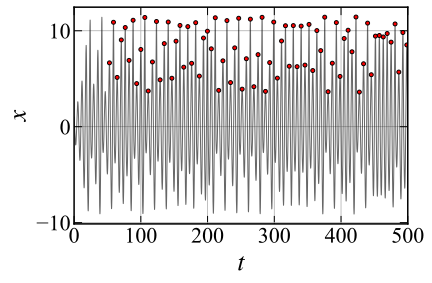

In [27]:
# solve RS
T=500; dt=0.02; t0=50; t0_=int(t0/dt)
xyz0 = [1,1,0]
c0=5.7; a0=b0=0.2
t, xyz = txyz_RS(a0,b0,c0,T,dt,xyz0)

# Plot x-t [0<t<T]
fig_xt, ax = plt.subplots(figsize=(6,4))
ax.plot(t, xyz[:,0],'k-',lw=1,alpha=0.6)

t_n,_ = find_peaks(xyz[t0_:,0],height=0)
x_n = xyz[t0_:,0][t_n]
ax.plot(t_n*dt+t0,x_n,'o',ms=4,mfc='r',mec='k')

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.grid()
ax.set_xlim(0,T)
# fig_xt.savefig('FIGS/12_RX-xt.pdf')
plt.show()

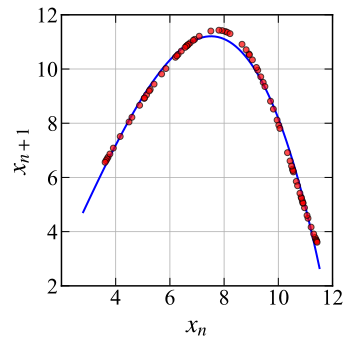

In [28]:
# Lorenz Map: x_max(n+1)=f[x_max(n)]
x1=2; x2=12; 
xx = np.linspace(x1*1.4,x2*0.96,80)

# find f(x)=a0+a1.x+a2.x^2+a3.x^3 through fitting x_max(n+1) vs x_max(n)
def RSx_fit(x,a0,a1,a2,a3):
    return a0+a1*x+a2*x**2+a3*x**3
params = curve_fit(RSx_fit,x_n[:-1],x_n[1:])
a0,a1,a2,a3 = params[0]

# plot Lorentz Map 
fig_LM, ax = plt.subplots(figsize=(5,5))
ax.plot(xx,RSx_fit(xx,a0,a1,a2,a3),'b-',lw=2)
ax.plot(x_n[:-1],x_n[1:],'o',ms=6,mfc='r',mec='k',mew=1,alpha=0.7)
ax.set_xlabel('$x_{n}$')
ax.set_ylabel('$x_{n+1}$')
ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(x1,x2)
ax.set_xticks(np.arange(x1,x2,2)+2)
ax.grid()
# plt.savefig('FIGS/12_RS-xLM.pdf')
plt.show()

In [30]:
# Plot Orbit Diagram of x_max(c)
# calculate x_max(c)
def x_max(c, a=0.2,b=0.2,T=500,dt=0.02,t0=50):
    t0_=int(t0/dt)
    xyz0 = [1,1,0]
    t, xyz = txyz_RS(a,b,c,T,dt,xyz0)
    t_n,_ = find_peaks(xyz[t0_:,0],height=0)
    x_n = xyz[t0_:,0][t_n]
    return x_n
# plot OD
fig_RS_OD, ax=plt.subplots(figsize=(6,4))
for r0 in np.linspace(2.5,6,200):
    yy=x_max(r0)
    xx=np.ones(len(yy))*r0
    ax.plot(xx,yy,'o',ms=0.4,mfc='r',mec='r',mew=0.4)
ax.grid()
ax.set_xlim(2.5,6)
ax.set_xticks(np.arange(3,6.5,0.5))
ax.set_yticks(np.arange(2,13,2))
ax.set_ylim(2,13)
ax.set_xlabel('$c$')
ax.set_ylabel('$x_{max}$')
plt.close()

In [31]:
# fig_RS_OD.savefig('FIGS/12_RS_OD.pdf')

In [ ]:
# Plot Orbit Diagram of x_max(c)
# calculate x_max(c)
def x_max(c, a=0.2,b=0.2,T=500,dt=0.02,t0=50):
    t0_=int(t0/dt)
    xyz0 = [1,1,0]
    t, xyz = txyz_RS(a,b,c,T,dt,xyz0)
    t_n,_ = find_peaks(xyz[t0_:,0],height=0)
    x_n = xyz[t0_:,0][t_n]
    return x_n
# plot OD
fig_RS_OD2, ax=plt.subplots(figsize=(6,4))
for r0 in np.linspace(5.5,5.9,200):
    yy=x_max(r0)
    xx=np.ones(len(yy))*r0
    ax.plot(xx,yy,'o',ms=0.4,mfc='r',mec='r',mew=0.4)
ax.grid()
ax.set_xlim(5.5,5.9)
ax.set_xticks(np.arange(5.5,6.,0.1))
ax.set_ylim(3,12)
ax.set_yticks(np.arange(4,13,2))
ax.set_xlabel('$c$')
ax.set_ylabel('$x_{max}$')
plt.show()

In [ ]:
# fig_RS_OD2.savefig('FIGS/12_RS_OD2.pdf')

## Forced Double-Well Oscillator

Equation of motion of a particle in a double-well potential, $V(x)=x^4/4-x^2/2$, driven by a time-dependent force $F(t)=F_0\cos(\omega t)$ is

$\ddot{x}(t)+\delta\dot{x}(t)+x^3(t)-x(t)=F_0\cos(\omega t)$, 

which is equivalent to the 3D autonomous dynamical system

$\dot{x}=y$

$\dot{y}=x-x^3-\delta y+F_0\cos(\omega z)$

$\dot{z}=1$

__Note:__ The dynamics of a mechanical system with 1 degree of freedom driven by a time-dependent force is often chaotic! Indeed, such system is equivalent to a 2D non-autonomous dynamical system, which is equivalent to a 3D autonomous dynamical system. 

In [ ]:
# functions to solve the Forced Double-Well Oscillator (F2WO) 
# input: parameters delta, F0, omega; duration T and timestep dt; initial condition xyz0=[x0,y0,0]
# output: sol = [x(t),y(t),z(t)=t]

def xyz_F2WO(delta,F0,omega,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[y,x-x**3-delta*y+F0*np.cos(omega*z),1]
    sol = odeint(RHS,xyz0,t)
    return sol

### $\delta=0.25$, $\omega=1$ and $F_0=0.18\;\;\rightarrow\;\;$ Limit Cycle

In [ ]:
delta=0.25; omega=1.; F0=0.18

# solve F2WO
T=200; dt=0.01; t0=50; t0_=int(t0/dt)
xyz0=[0,0,0]

xyz = xyz_F2WO(delta,F0,omega,T,dt,xyz0)

# Plot x-t [0<t<T]
fig_xt, ax = plt.subplots(figsize=(6,4))
ax.plot(xyz[:t0_,2], xyz[:t0_,0],'k-',lw=1,alpha=0.5)
ax.plot(xyz[t0_:,2], xyz[t0_:,0],'r-',lw=1,alpha=1)

ax.set_xlabel('$t$')
ax.set_xlim(0,T)
ax.set_ylabel('$x$')
ax.set_yticks(np.arange(0,1.3,0.2))
ax.grid()
# fig_xt.savefig('FIGS/12_F2WO-xt_1.pdf')
plt.show()

In [ ]:
# Plot x-y 
fig_xy, ax = plt.subplots(figsize=(6,4))
ax.plot(xyz[:,0], xyz[:,1],'k-',lw=0.5,alpha=0.5)
ax.plot(xyz[t0_:,0], xyz[t0_:,1],'r-',lw=2,alpha=1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.arange(0,1.3,0.2))
ax.set_yticks(np.arange(-0.4,0.5,0.2))
ax.grid()
# fig_xy.savefig('FIGS/12_F2WO-xy_1.pdf')
plt.show()

In [ ]:
# Poincare section {x_p,y_p}={x(2pi/omega*n),y(2pi/omega*n)}, n=0,1,...
# solve F2WO
T1=20000; dt1=1; t01=1000; t01_=int(t01/dt)
xyz0=[0,0,0]
xyz1 = xyz_F2WO(delta,F0,omega,T1,dt1,xyz0)

xt = interpolate(xyz1[:,2],xyz1[:,0])
yt = interpolate(xyz1[:,2],xyz1[:,1])
tT = np.arange(t01,T1,2*np.pi/omega)

fig_xyP, ax=plt.subplots(figsize=(6,4))
ax.plot(xt(tT),yt(tT),'o',ms=1,mfc='r',mec='r',mew=1)

ax.set_xlabel('$x_p$')
ax.set_ylabel('$y_p$')

ax.set_xlim(0,1.3)
ax.set_ylim(-0.5,0.5)
ax.set_xticks(np.arange(0,1.3,0.2))
ax.set_yticks(np.arange(-0.4,0.5,0.2))

ax.grid()
# fig_xyP.savefig('FIGS/12_F2WO-xp-yp_1a.pdf')
plt.show()

### $\delta=0.25$, $\omega=1$ and $F_0=0.40\;\;\rightarrow\;\;$ Strange Attractor (Chaos)

In [ ]:
delta=0.25; omega=1.; F0=0.40

# solve F2WO
T=300; dt=0.01; t0=50; t0_=int(t0/dt)
xyz0=[0,0,0]

xyz = xyz_F2WO(delta,F0,omega,T,dt,xyz0)

# Plot x-t [0<t<T]
fig_xt, ax = plt.subplots(figsize=(6,4))
ax.plot(xyz[:t0_,2], xyz[:t0_,0],'k-',lw=1,alpha=0.5)
ax.plot(xyz[t0_:,2], xyz[t0_:,0],'r-',lw=1,alpha=1)

ax.set_xlabel('$t$')
ax.set_xlim(0,T)
ax.set_xticks(np.arange(0,T*1.1,50))
ax.set_ylabel('$x$')
# ax.set_yticks(np.arange(0,1.3,0.2))
ax.grid()
# ax.set_xlim(0,T)
# fig_xt.savefig('FIGS/12_F2WO-xt_2.pdf')
plt.show()

In [ ]:
# Plot x-y 
fig_xy, ax = plt.subplots(figsize=(6,4))
ax.plot(xyz[:,0], xyz[:,1],'k-',lw=0.5,alpha=0.5)
ax.plot(xyz[t0_:,0], xyz[t0_:,1],'r-',lw=1,alpha=1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.arange(-1.5,2,0.5))
ax.set_yticks(np.arange(-1,1.1,0.5))
ax.grid()
# ax.set_xlim(0,T)
# fig_xy.savefig('FIGS/12_F2WO-xy_2.pdf')
plt.show()

In [ ]:
# Poincare section {x(2pi/omega*n),y(2pi/omega*n)}, n=0,1,...
# solve F2WO
delta=0.25; omega=1.; F0=0.40
T1=20000; dt1=1; t01=1000; t01_=int(t01/dt)
xyz0=[0,0,0]
xyz1 = xyz_F2WO(delta,F0,omega,T1,dt1,xyz0)

xt = interpolate(xyz1[:,2],xyz1[:,0])
yt = interpolate(xyz1[:,2],xyz1[:,1])
tT = np.arange(0,T1,2*np.pi/omega)

fig_xyP, ax=plt.subplots(figsize=(6,4))
ms=0.8
ax.plot(xt(tT),yt(tT),'o',ms=ms,mfc='r',mec='r',mew=ms)

ax.set_xlabel('$x_p$')
ax.set_ylabel('$y_p$')
ax.set_xlim(-2,2)
ax.set_ylim(-0.7,1.3)
ax.grid()
# fig_xyP.savefig('FIGS/12_F2WO-xp-yp_2.pdf')
plt.show()

In [ ]:
# Poincare section: starting time (tp) dependence
@interact(tp=(0,T1/2,t01))
def update(tp=0):
    tT = np.arange(tp,T1,2*np.pi/omega)

    fig_xy, ax=plt.subplots(figsize=(6,4))
    ms=0.8
    ax.plot(xt(tT),yt(tT),'o',ms=ms,mfc='r',mec='r',mew=ms)

    ax.set_xlabel('$x_p$')
    ax.set_ylabel('$y_p$')
    ax.set_xlim(-2,2)
    ax.set_ylim(-1.3,1.3)
    # ax.set_xticks(np.arange(0,1.3,0.2))
    # ax.set_yticks(np.arange(-0.4,0.5,0.2))
    ax.grid()
    plt.show()

### $\delta=0.25$, $\omega=1$ and $F_0=0.25\;\;\rightarrow\;\;$ Transient Chaos

In [ ]:
delta=0.25; omega=1.; F0=0.25
# 2 nearby trajectories with transient chaos 
#   converging to different limit cycles 
xyz01=[0.200,0.1,0]
xyz02=[0.195,0.1,0]

# solve F2WO
T=300; dt=0.01; t0=200; t0_=int(t0/dt)

xyz1 = xyz_F2WO(delta,F0,omega,T,dt,xyz01)
xyz2 = xyz_F2WO(delta,F0,omega,T,dt,xyz02)

# Plot x-t [0<t<T]
fig_xt, ax = plt.subplots(2,1,figsize=(6,6),sharex=True,
                gridspec_kw = {'wspace':0.02,'hspace':0.02})
ax[0].plot(xyz1[:t0_,2], xyz1[:t0_,0],'k-',lw=1,alpha=0.5,label='$x_0={},\;y_0={}$'.format(xyz01[0],xyz01[1]))
ax[0].plot(xyz1[t0_:,2], xyz1[t0_:,0],'r-',lw=1,alpha=1)
ax[1].plot(xyz2[:t0_,2], xyz2[:t0_,0],'k-',lw=1,alpha=0.5,label='$x_0={},\;y_0={}$'.format(xyz02[0],xyz02[1]))
ax[1].plot(xyz2[t0_:,2], xyz2[t0_:,0],'b-',lw=1,alpha=1)

ax[1].set_xlabel('$t$')
ax[1].set_xlim(0,T)
ax[1].set_xticks(np.arange(0,T*1.1,50))
ax[1].set_ylabel('$x$')
ax[1].yaxis.set_label_coords(-0.07,1)
[a.grid() for a in ax]
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
ax[0].text(130,0,'$x_0={},\;y_0={}$'.format(xyz01[0],xyz01[1]),fontsize=18,color='r',
           bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))
ax[1].text(130,0,'$x_0={},\;y_0={}$'.format(xyz02[0],xyz02[1]),fontsize=18,color='b',
           bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))
# fig_xt.savefig('FIGS/12_F2WO-xt_3.pdf')
plt.show()

In [ ]:
# Plot x-y 
fig_xy, ax = plt.subplots(2,1,figsize=(6,6),sharex=True,
                gridspec_kw = {'wspace':0.02,'hspace':0.02})
ax[0].plot(xyz1[:t0_,0], xyz1[:t0_,1],'k-',lw=1,alpha=0.5,label='$x_0={},\;y_0={}$'.format(xyz01[0],xyz01[1]))
ax[0].plot(xyz1[t0_:,0], xyz1[t0_:,1],'r-',lw=2,alpha=1)
ax[1].plot(xyz2[:t0_,0], xyz2[:t0_,1],'k-',lw=1,alpha=0.5,label='$x_0={},\;y_0={}$'.format(xyz02[0],xyz02[1]))
ax[1].plot(xyz2[t0_:,0], xyz2[t0_:,1],'b-',lw=2,alpha=1)

ax[1].set_xlabel('$x$')
# ax[1].set_xlim(0,T)
# ax[1].set_xticks(np.arange(0,T*1.1,50))
ax[1].set_ylabel('$y$')
ax[1].yaxis.set_label_coords(-0.12,1)
[a.grid() for a in ax]
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
ax[0].text(-0.56,0.63,'$x_0={},\;y_0={}$'.format(xyz01[0],xyz01[1]),fontsize=18,color='r')
ax[1].text(-0.65,-0.75,'$x_0={},\;y_0={}$'.format(xyz02[0],xyz02[1]),fontsize=18,color='b')
# fig_xy.savefig('FIGS/12 _F2WO-xy_3.pdf')
plt.show()